# Yelp Review Humor Detection
## Running the notebook
To run this Jupyter notebook, you can clone the [Conda](https://conda.io/docs/) environment that I used by installing the dependencies listed in the spec-file.txt in this repository. Simply run

`conda create --name myenv --file spec-file.txt
source activate myenv`

where "myenv" is the name of your environment. Then, to get the word vectors, download the spaCy model with 

`python -m spacy download en_vectors_web_lg`

My Python version is 3.6.2.

## The premise
Plenty of machine learning research has investigated sentiment analysis in the context of positive versus negative online reviews. By contrast, very few works have focused on computational humor... in this case, the detection of _funny_ reviews.

[Oliveira & Rodrigo](https://cs224d.stanford.edu/reports/OliveiraLuke.pdf) determined that making such predictions is quite possible with a variety of machine learning architectures. This notebook attempts to reproduce a subset of their results - specifically, the accuracy they obtained from the use of a recurrent neural network (RNN).

## The problem
Using the [Yelp Open Dataset](https://www.yelp.com/dataset) of over 4 million business reviews, I want to see if it's possible to train a classifier that will correctly determine whether a Yelp review is funny or not. Humor, of course, is a largely subjective measure. Yelp allows users to mark a particular review as being funny. So, to more rigorously define the binary classification problem and the source of truth, I use the same assumption made by Oliveira & Rodrigo: that a review is "funny" if it has 3 or more "funny" votes.

## The approach
A review can be seen as a sequence of word vectors, where each vector represents a similarity measure for a particular "token" in the review. A token can be a word, punctuation mark, etc. (The exact tokenization of a review is dependent on the language in which it is written.) We can view these sequences as many-to-one mappings via an RNN that outputs a single label, denoting "funny" or "not funny," after feeding it an entire sequence. With an RNN that includes memory units in its architecture, we can attempt to capture long-term dependencies within the text for improved classification.

### Overview of the data
Let's begin by first looking at what a single Yelp review looks like from our dataset. I can't include the JSON file due to its size (and possibly some restrictions on how it should be shared), so **don't run the code block below!** Just observe the output. If you want to replicate this work, you'll want to get the dataset yourself from the link above.

In [2]:
### DON'T RE-RUN THIS BLOCK

import json

total = 0
num_funny = 0
funny_threshold = 3
with open('yelp_dataset/review.json') as reviews_file:
    for line in reviews_file:
        total += 1
        review = json.loads(line)
        if total == 1:
            # Let's print the very first review, just to see what it looks like.
            print(review)
        if review['funny'] >= funny_threshold:
            num_funny += 1
            
print('\nTotal reviews: %d\nFunny reviews: %d\nNormal reviews: %d' % (total, num_funny, total - num_funny))

{'review_id': 'VfBHSwC5Vz_pbFluy07i9Q', 'user_id': 'cjpdDjZyprfyDG3RlkVG3w', 'business_id': 'uYHaNptLzDLoV_JZ_MuzUA', 'stars': 5, 'date': '2016-07-12', 'text': 'My girlfriend and I stayed here for 3 nights and loved it. The location of this hotel and very decent price makes this an amazing deal. When you walk out the front door Scott Monument and Princes street are right in front of you, Edinburgh Castle and the Royal Mile is a 2 minute walk via a close right around the corner, and there are so many hidden gems nearby including Calton Hill and the newly opened Arches that made this location incredible.\n\nThe hotel itself was also very nice with a reasonably priced bar, very considerate staff, and small but comfortable rooms with excellent bathrooms and showers. Only two minor complaints are no telephones in room for room service (not a huge deal for us) and no AC in the room, but they have huge windows which can be fully opened. The staff were incredible though, letting us borrow umbr

As you can probably guess, for our purposes, the most important fields in a Yelp review "data point" are the 'text' and 'funny' keys. The 'text' key maps to the text of the review, which will ultimately be transformed into a sequence of word vectors. The 'funny' key maps to the number of "funny" votes that the review received from other Yelp users. If this value is greater than or equal to the funny threshold (set at 3), then the review is labeled as funny. Otherwise, it's not funny.

To create my own dataset, I simply read through the JSON file and store the reviews as a list of dictionaries, with each dictionary representing a single sample containing the text of a particular review along with its label **(0 for not funny, 1 for funny)**. I stop reading the JSON file when I've created a balanced dataset of the desired size, with equal numbers of funny and not funny reviews. **The first half of the dataset consists entirely of funny reviews while the second half contains only of not funny reviews.** This observation will allow me to easily split the dataset for training/testing while still maintaining balanced sets.

I wrap this dataset inside a PyTorch Dataset object to take advantage of easier training/testing splitting afforded by the Sampler and DataLoader classes. To save time, I loaded the dataset through a pickle.

In [1]:
import pickle
from torch.utils.data import Dataset

class ReviewsDataset(Dataset):
    def __init__(self, reviews=[], fields=['text']):
        '''
        Args:
            reviews (List[dict]): List of dictionaries, each one a sample from the dataset
            fields (List[string]): List of fields to extract from each review
        '''
        self.reviews = reviews
        self.fields = fields
        
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        return self.reviews[idx]
    
    def read_from_file(self, raw_data_path, count=2000, pickle_filename=None, funny_threshold=3):
        '''
        Reads a JSON file containing the Yelp reviews and creates a dataset from the raw data.
        Args:
            raw_data_path (string): Path to the Yelp JSON file
            count (int): Number of reviews to extract from each label (dataset size will be twice this number)
            pickle_filename (string): Name used for the pickled dataset; if None, pickle is not created
            funny_threshold (int): Number of "funny" votes needed for a review to be considered funny
        '''
        funny_reviews = []
        not_funny_reviews = []
        with open(raw_data_path) as reviews_file:
            for line in reviews_file:
                # Break when we've created a balanced dataset with count reviews in each category.
                if len(funny_reviews) == count and len(not_funny_reviews) == count:
                    break
                    
                sample = {}
                review = json.loads(line)
                for f in self.fields:
                    sample[f] = review[f]
                    
                if review['funny'] >= funny_threshold and len(funny_reviews) < count:
                    sample['label'] = 1
                    funny_reviews.append(sample)
                elif review['funny'] < funny_threshold and len(not_funny_reviews) < count:
                    sample['label'] = 0
                    not_funny_reviews.append(sample)
        
        # Notice that the first half of self.reviews is all funny reviews 
        # and the second half is all not funny reviews.
        self.reviews = funny_reviews + not_funny_reviews[:len(funny_reviews)]
        
        if pickle_filename is not None:
            print('Pickling %d reviews...' % (len(self)))
            pickle.dump(self.reviews, open(pickle_filename, 'wb'))
            print('Pickled as %s' % (pickle_filename))
            
        print('Loaded a balanced dataset of %d reviews!' % (len(self.reviews)))

    def read_from_pickle(self, pickle_path):
        '''
        Loads a dataset from a pickle.
        Args:
            pickle_path: Path to the pickle file to be used
        '''
        print('Loading from pickle...')
        self.reviews = pickle.load(open(pickle_path, "rb"))
        print('Loaded %d reviews from %s!' % (len(self), pickle_path))
    
data = ReviewsDataset()
# data.read_from_file('yelp_dataset/review.json', 50000, 'dataset.p')
data.read_from_pickle('dataset.p')

Loading from pickle...
Loaded 100000 reviews from dataset.p!


Here's a single sample from my dataset (the review is kind of funny, I guess, but maybe I should have bumped up the humor threshold).

In [2]:
print(data[200])

{'text': 'Slots-A-Fun has very strange odor. A mixture of cigarettes, hot dogs, pizza, B.O., and industial strength cleaner (the kind they use in the "adult" bookstores). I took a couple friends through here on the obligatory ten minute tour. Enough time to buy a couple beers, lose $3 in a slot machine (at least I got a quarter back!!! A real quarter-not a coupon-the only reason this place gets 2 stars!) and cruise by the $1 roulette table. I was hoping to teach my table game-wary friend how to play a simple game of roulette, but the proliferation of Lil\' John and Ludacris wannabes hovering nearby scared her away. YEEEEAAAAH! Oh well- I never do well at those low limit tables anyway. I played craps here once and dealers were extemely rude. I wonder why this place, and circus circus,still exist when everything else nearby has been imploded.', 'label': 1}


### Tokenizing the data
Each review sample must be converted into a sequence of word vectors before it can be fed through the RNN. To make this conversion, I use the [spaCy](https://spacy.io/) library, which allows one to easily tokenize a text and generate word vectors for each token.

In [3]:
import spacy
nlp = spacy.load('en_vectors_web_lg')

# Example of using spaCy to generate tokens
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')
for token in doc:
    print(token.text)

Apple
is
looking
at
buying
U.K.
startup
for
$
1
billion


These vectors (of length 300) will then be converted into PyTorch tensors and fed, one at a time and in order, into the RNN.

In [4]:
import torch

def token2tensor(token):
    return torch.from_numpy(token.vector)

One unresolved issue here is the fact that some tokens do not have word vectors. A common reason for this problem is that the token represents a word that is out-of-vocabulary or a lot less common than others (or, in the case of Yelp reviews, the word is misspelled).

In those cases, `token.vector` simply returns a zero-vector. There's a good chance that these words are negatively impacting the learning process, since zero-vectors are treated no differently by the RNN. Skipping over the word doesn't seem like the best idea (since we want to preserve the sequence of words as much as possible), so for now, I'm betting on the zero-vector not showing up enough during training to matter in the grand scheme of things.

### The RNN
Now that we've defined our input to the RNN, let's make the network itself. The RNN uses Gated Recurrent Units (GRU) with 128 hidden units and a dropout ratio of 0.5. The input and hidden sequences are also sent through a linear transformation and LogSoftmax layer to generate the output (label).

In [5]:
import torch.nn as nn
from torch.autograd import Variable

# create the RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        '''
        Initialize the RNN layers.
        Args:
            input_size: Length of the input word vector
            hidden_size: Number of hidden units in the RNN
        '''
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.input2hidden = nn.GRU(input_size, hidden_size, dropout=0.5)
        self.input2output = nn.Linear(input_size + hidden_size, out_features=2)
        self.softmax = nn.LogSoftmax()
        
    def initHidden(self):
        '''
        Initialize all hidden sequences to zero.
        '''
        return Variable(torch.zeros(1, 1, self.hidden_size))
    
    def forward(self, input, hidden):
        '''
        Generate a new hidden state and output given an input vector and current hidden state.
        Args:
            input (Variable): The input word tensor
            hidden (Variable): The last hidden state tensor
            
        Returns:
            output (Tensor): 2x1 tensor representing likelihoods that a review is funny based on the input so far
            hidden (Tensor): The next hidden state tensor
        '''
        # Combine the input and hidden tensors for use in generating the output.
        # We use index 0 for the first two dimensions because the tensor dimensions 
        # are structured as (Number of Batches x Number of Instances Per Batch x Length of Each Instance's Tensor)
        combined = torch.cat((input[0,0,:], hidden[0,0,:]))
        
        # Generate next hidden state.
        hidden, _ = self.input2hidden(input, hidden)
        
        # Generate next output label by passing the previous input and hidden state through 
        # a linear transformation and LogSoftmax layer.
        output = self.input2output(combined)
        output = self.softmax(output)
        return output, hidden
    
# data specifications
input_size = 300 # length of a single word vector
hidden_units = 128

# initialize the RNN
model = RNN(input_size, hidden_units)

As mentioned earlier, I train the RNN by taking each sample's text and feeding the word vectors for each token one at a time as input. I optimize on the negative log-likelihood loss function using the _adam_ optimizer.

To make a prediction given a particular review, I first do the same thing as I do when training except I don't use the output to optimize the network parmeters. Then, I simply return the index (1 if funny, 0 if not funny) of the maximum value of the 2-length vector output.

In [6]:
import torch.optim as optim

# training specifications
criterion = nn.NLLLoss() # negative log-likelihood loss function
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train_one(review):
    '''
    Trains the RNN on one review.
    Args:
        review (Dictionary): A batch containing a single review
        
    Returns:
        output (Tensor): 2x1 tensor representing likelihoods that a review is funny based on the input so far
        loss (float): The value of the loss function at the last layer of the RNN
    '''
    # Zero out the model gradients and hidden state so they aren't influenced by previous reviews.
    model.zero_grad()
    hidden = model.initHidden()
    
    # review is technically a batch, so we take the text of the first sample of the batch...
    # (hence the 0 index)
    doc = nlp(review['text'][0])
    
    # Feed the input one token at a time through our model.
    for token in doc:
        input_tensor = torch.zeros(1, 1, input_size)
        input_tensor[0,0,:] = token2tensor(token)
        output, hidden = model(Variable(input_tensor), hidden)
        
    # Calculate the loss functions at each layer; backpropagate and optimize.
    loss = criterion(torch.unsqueeze(output, 0), Variable(torch.Tensor([review['label'][0]]).long()))
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

def get_label(output):
    '''
    Determine whether an output tensor says a review is funny or not funny.
    Args:
        output: 2x1 tensor
        
    Returns: 
        1 if the review corresponding to the tensor is more likely to be funny than not funny.
        0 otherwise.
    '''
    _, indices = output.data.topk(1)
    return indices[0]

def predict(review):
    '''
    Predict whether a review is funny or not funny.
    Args:
        review (Dictionary): A batch containing a single review
        
    Returns:
        1 if the review corresponding to the tensor is more likely to be funny than not funny.
        0 otherwise.
    '''
    hidden = model.initHidden()
    doc = nlp(review['text'][0])
    for token in doc:
        input_tensor = torch.zeros(1, 1, input_size)
        input_tensor[0,0,:] = token2tensor(token)
        output, hidden = model(Variable(input_tensor), hidden)

    return get_label(output)

### Training and testing
Now, it's time to train the model on the dataset. First, I split the dataset into a training set and a testing set such that both sets remain balanced. Since the first half of the full dataset consists of funny reviews and the second half consists of not funny reviews, I can simply take half of the testing set from the front of the dataset and half from the back. The rest of the reviews become my training set.

In [7]:
# 5% of the dataset (5,000 reviews for a 100,000-review dataset) is used for testing/validation.
valid_size = 0.05
total = len(data)
indices = list(range(total))
num_validation_samples = int(total / 2 * (valid_size)) # Each label makes up half of the testing set.

testing_indices = indices[:num_validation_samples] + indices[-num_validation_samples:]
training_indices = indices[num_validation_samples:-num_validation_samples]
num_testing = len(testing_indices)
num_training = len(training_indices)
print('Training set has %d samples, validation set has %d samples' % (num_training, num_testing))

Training set has 95000 samples, validation set has 5000 samples


Finally, we can train. On my laptop, training on just one epoch of a set of 95,000 reviews takes over 10 hours. However, in the event that I ever train for multiple epochs, I've implemented a stop condition for whenever the testing accuracy drops from one epoch to the next. That way, we might avoid overfitting to the training set (though the dropout should help as well).

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import math, time

def timeSince(since):
    '''
    Get the amount of time that has elapsed since some reference time.
    Args:
        since (float): The reference time
        
    Returns:
        (string): Amount of time in minutes and seconds that has elapsed since the reference time
    '''
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def train(training_set, testing_set, epochs=1):
    '''
    Trains the RNN.
    Args:
        training_set (DataLoader): The training set
        testing_set (DataLoader): The testing set
        epochs (int): Number of epochs
        
    Returns:
        loss_function (List[float]): List of loss function values aggregated over len(training_set)/200 sample intervals.
    '''
    start = time.time()
    print_every = int(len(training_set) / 20)
    plot_every = int(len(training_set) / 200)
    loss_function = []
    total_loss = 0 # Keep track of loss function values over the course of training plot_every samples.
    prev_accuracy = 0 # Testing accuracy after training on the previous epoch.
    for epoch in range(epochs):
        print('Epoch %d' % (epoch))
        for i, batch in enumerate(training_set):
            # Each batch has just one sample/review.
            output, loss = train_one(batch)
            total_loss += loss
            guess = get_label(output)

            # Print sample number, progress percentage, and the loss and guess for that particular sample at regular intervals.
            if i % print_every == 0:
                correct = '✓' if get_label(output) == batch['label'][0] else '✗ (%s)' % batch['label'][0]
                print('Sample %d Progress: %d%% (%s) Loss: %.4f Guess: %d %s' % (i, i / (len(training_set) * epochs) * 100, timeSince(start), loss, guess, correct))

            if i % plot_every == 0 and i > 0:
                loss_function.append(total_loss / plot_every)
                total_loss = 0

        print('Testing now...')
        accuracy = test(testing_set)
        print('Testing accuracy after epoch %d: %.4f%%' % (epoch, accuracy * 100))
        if accuracy < prev_accuracy:
            print('Testing accuracy dropped... model appears to be overfitting. Stopping training at epoch %d.' % (epoch))
            break
        else:
            prev_accuracy = accuracy
            
    return loss_function

def test(testing_set):
    '''
    Tests the RNN.
    Args:
        testing_set (DataLoader): The testing set
        
    Returns:
        accuracy (float): Testing accuracy
    '''
    correct = 0
    print_every = int(len(testing_set) / 20)
    start = time.time()
    for i, batch in enumerate(testing_set):
        # Again, each batch has just one review.
        correct += 1 if predict(batch) == batch['label'][0] else 0
        
        # Print statements at regular intervals to indicate testing progress.
        if i % print_every == 0:
            print('Sample %d Progress: %d%% (%s) Accuracy: %.4f' % (i, i / len(testing_set) * 100, timeSince(start), correct / (i + 1)))
    
    accuracy = correct / len(testing_set)
#     print('Testing accuracy: %.4f' % (accuracy))
    return accuracy

The output below the next cell shows the progress of the overnight training and testing process. As you can see, the model achieves a testing accuracy of around 75%. Pretty good and only a little less than the accuracy achieved by Oliviera & Rodrigo.

In [8]:
### DON'T RUN THIS BLOCK UNLESS YOU WANT TO TRAIN AGAIN
training_set = DataLoader(dataset=data, sampler=SubsetRandomSampler(training_indices))
testing_set = DataLoader(dataset=data, sampler=SubsetRandomSampler(testing_indices))
loss_function = train(training_set, testing_set, epochs=1)

Epoch 0
Sample 0 Progress: 0% (0m 0s) Loss: 0.6776 Guess: 0 ✓
Sample 4750 Progress: 5% (35m 57s) Loss: 0.7309 Guess: 0 ✗ (1)
Sample 9500 Progress: 10% (83m 31s) Loss: 0.7166 Guess: 1 ✗ (0)
Sample 14250 Progress: 15% (117m 11s) Loss: 0.5417 Guess: 0 ✓
Sample 19000 Progress: 20% (150m 11s) Loss: 0.6048 Guess: 1 ✓
Sample 23750 Progress: 25% (182m 17s) Loss: 0.8632 Guess: 1 ✗ (0)
Sample 28500 Progress: 30% (212m 56s) Loss: 0.6235 Guess: 0 ✓
Sample 33250 Progress: 35% (242m 50s) Loss: 0.9318 Guess: 1 ✗ (0)
Sample 38000 Progress: 40% (273m 3s) Loss: 1.2925 Guess: 0 ✗ (1)
Sample 42750 Progress: 45% (302m 42s) Loss: 0.1228 Guess: 0 ✓
Sample 47500 Progress: 50% (332m 27s) Loss: 0.1150 Guess: 0 ✓
Sample 52250 Progress: 55% (362m 31s) Loss: 0.2325 Guess: 1 ✓
Sample 57000 Progress: 60% (393m 1s) Loss: 0.2295 Guess: 1 ✓
Sample 61750 Progress: 65% (423m 41s) Loss: 0.2383 Guess: 1 ✓
Sample 66500 Progress: 70% (453m 52s) Loss: 0.3823 Guess: 1 ✓
Sample 71250 Progress: 75% (483m 37s) Loss: 0.2018 Guess:

In the run above, we see that the classifier was able to achieve an accuracy of 74.5% on the 5,000-review testing set. Oliveiria & Rodrigo managed to get a test accuracy of around 78%, so we aren't too far off! We can plot the loss function to see it slowly converging (though it's clearly jumping around a lot).

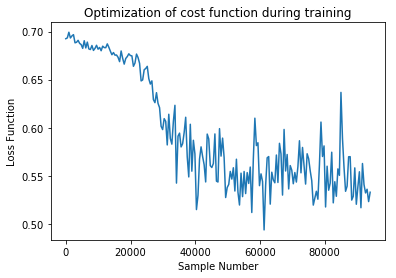

In [9]:
### DON'T RUN THIS BLOCK IF YOU DIDN'T RUN THE LAST ONE

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

fig = plt.figure()
plt.plot([i * int(num_training / 200) for i in range(len(loss_function))], loss_function)
plt.title('Optimization of cost function during training')
plt.xlabel('Sample Number')
plt.ylabel('Loss Function')

## The results
Since it takes so long to train the classifier, I've saved the parameters of my best model, trained on 95,000 reviews. In the next code block, I load the parameters into a new RNN and test the accuracy on a small 600-sample testing set. The testing here runs fairly quickly, so feel free to run the block to see the model in action! Make sure you've downloaded the dataset and successfully ran all of the code blocks above **except** for the very first block and the two immediately before this one.

In [9]:
# Create new RNN
model = RNN(input_size, hidden_units)

# Load the learned parameters into the RNN from a file
model.load_state_dict(torch.load('model_100000'))

# Create the testing set of 600 samples
small_testing_indices = indices[:300] + indices[-300:]
small_testing_set = DataLoader(dataset=data, sampler=SubsetRandomSampler(small_testing_indices))

accuracy = test(small_testing_set)
print('Testing accuracy on %d samples: %.4f%%' % (len(small_testing_set), accuracy * 100))

Sample 0 Progress: 0% (0m 0s) Accuracy: 1.0000
Sample 30 Progress: 5% (0m 4s) Accuracy: 0.9032
Sample 60 Progress: 10% (0m 9s) Accuracy: 0.8525
Sample 90 Progress: 15% (0m 15s) Accuracy: 0.8791
Sample 120 Progress: 20% (0m 19s) Accuracy: 0.8760
Sample 150 Progress: 25% (0m 24s) Accuracy: 0.8742
Sample 180 Progress: 30% (0m 31s) Accuracy: 0.8343
Sample 210 Progress: 35% (0m 39s) Accuracy: 0.8199
Sample 240 Progress: 40% (0m 46s) Accuracy: 0.8257
Sample 270 Progress: 45% (0m 53s) Accuracy: 0.8303
Sample 300 Progress: 50% (0m 58s) Accuracy: 0.8272
Sample 330 Progress: 55% (1m 1s) Accuracy: 0.8218
Sample 360 Progress: 60% (1m 7s) Accuracy: 0.8283
Sample 390 Progress: 65% (1m 13s) Accuracy: 0.8184
Sample 420 Progress: 70% (1m 17s) Accuracy: 0.8100
Sample 450 Progress: 75% (1m 24s) Accuracy: 0.8049
Sample 480 Progress: 80% (1m 32s) Accuracy: 0.8046
Sample 510 Progress: 85% (1m 36s) Accuracy: 0.8063
Sample 540 Progress: 90% (1m 43s) Accuracy: 0.8133
Sample 570 Progress: 95% (1m 48s) Accuracy:

81.1667%... Not bad, and definitely better than random guessing!

## Future improvement
To speed up the training process in the future, I'd like to investigate the use of padding to group word vectors into equal-length batches so that training them can be parallelized.